<a href="https://colab.research.google.com/github/Nadiam75/DeepLearning_HW_3/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install transformers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)
from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [2]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [4]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [5]:
testData = testData.loc[testData["polarity"] != 2]

In [6]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [8]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

In [9]:
testData.shape  , trainData.shape

((358, 2), (1599999, 2))

In [10]:
trainData.head()

,polarity,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [11]:
 trainData = trainData.reindex(np.random.permutation(trainData.index))

In [12]:
trainData.head()

,polarity,text
45339,0,What? Its a classic...
418349,0,"@iRockaBerry hahaha yes, I can't wait for the ..."
621568,0,"@dj_wonder Don't worry about it, you have to h..."
1323994,1,watching boys over flowers.cute!
236751,0,grrr the twitter thing wont upload my picture ...


In [13]:
testData.head()

,polarity,text
0,1,Reading my kindle2... Love it... Lee childs i...
1,1,"Ok, first assesment of the #kindle2 ...it fuck..."
2,1,@kenburbary You'll love your Kindle2. I've had...
3,1,@mikefish Fair enough. But i have the Kindle2...
4,1,@richardebaker no. it is too big. I'm quite ha...


In [14]:
 testData = testData.reindex(np.random.permutation(testData.index))

In [15]:
testData.head()

,polarity,text
81,1,@accannis @edog1203 Great Stanford course. Tha...
256,1,@cthagod when Lebron is done in the NBA he wil...
387,0,Cox or Time Warner? Cox is cheaper and gets a...
41,0,cant sleep... my tooth is aching.
488,1,i lam so in love with Bobby Flay... he is my f...


In [16]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [17]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # for tweet in textdata:
    tweet =textdata
    # print(tweet)
    tweet = tweet.lower()
    
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # Checking if the word is a stopword.
        #if word not in stopwordlist:
        if len(word)>1:
            # Lemmatizing the word.
            word = wordLemm.lemmatize(word)
            tweetwords += (word+' ')
        
    processedText.append(tweetwords)
        
    return processedText[0]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
trainData['text'] = trainData.text.apply(preprocess)

In [19]:
testData['text'] = testData.text.apply(preprocess)

In [20]:
trainData.head()

,polarity,text
45339,0,what it classic
418349,0,USER hahaha yes can wait for the 9630 to come ...
621568,0,USER don worry about it you have to have had 1...
1323994,1,watching boy over flower cute
236751,0,grr the twitter thing wont upload my picture s...


In [21]:
testData.head()

,polarity,text
81,1,USER USER great stanford course thanks for mak...
256,1,USER when lebron is done in the nba he will pr...
387,0,cox or time warner cox is cheaper and get on d...
41,0,cant sleep my tooth is aching
488,1,lam so in love with bobby flay he is my favori...


In [22]:
train_labels = trainData.polarity.values
train_text = trainData.text.values

In [23]:
test_labels = testData.polarity.values
test_text = testData.text.values

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [25]:
input_ids_ = []
attention_mask_ = []
for i in train_text:
    encoded_data = tokenizer.encode_plus( i, add_special_tokens=True, max_length=64, pad_to_max_length = True, return_attention_mask= True,
    return_tensors='pt')
    input_ids_.append(encoded_data['input_ids'])
    attention_mask_.append(encoded_data['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
input_ids = torch.cat(input_ids_,dim=0)
attention_mask = torch.cat(attention_mask_,dim=0)
train_labels = torch.tensor(train_labels)

In [27]:
input_ids.shape

torch.Size([1599999, 64])

In [28]:
attention_mask.shape

torch.Size([1599999, 64])

In [29]:
train_labels.shape

torch.Size([1599999])

In [30]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [31]:
num = 1000
dataset = TensorDataset(input_ids[:num],attention_mask[:num],train_labels[:num])
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  800
Validation Size -  200


In [32]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 64)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 64)

In [33]:
len(train_dl),len(val_dl)

(13, 4)

In [34]:
model = BertForSequenceClassification.from_pretrained( 'bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [37]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

In [38]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [39]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [40]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [57]:
losses = []
accuracies = []
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        acc= outputs [1]
        accuracies.append(acc)
        loss_train_total += loss.item()
        losses.append(loss.item())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6647922259110671
Validation loss: 0.6470984816551208
Accuracy: 0.605


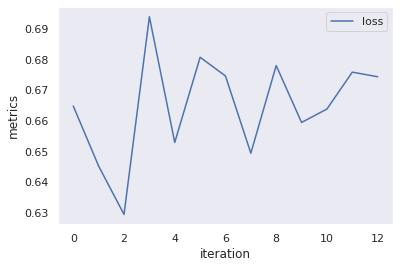

In [59]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('metrics')
plt.xlabel('iteration')
plt.legend(['loss'])
plt.grid()

plt.show()

In [60]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [61]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [62]:
def predictSentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus( sent, add_special_tokens = True, max_length = 64, pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt', )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [63]:
ans = predictSentiment('happy, healthy and energetic')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [67]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Positive


In [68]:
ans = predictSentiment('i hate you')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [69]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [70]:
pred = predictSentiment('it was a wonderful event')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [71]:
if pred == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [ ]:
predictions = []
for row in testData.iterrows():
  selected_sentence = row[1]['text']
  pred = predictSentiment(selected_sentence)
  predictions.append(pred.item())

  if pred == 1 :
    result = 'positive'
  else:
    result = 'negative'
  if  row[1]['polarity'] == 1:
    polarity = 'positive'
  else: 
    polarity = 'negative'
  
  # print("selected sentence: " , selected_sentence)
  # print("actual label=  " , polarity)
  # print("predicted label= " , result)
  # print("********************************************************************")

In [121]:
def create_confusion_matrix(y_true, y_pred , amount_classes):
    confusion_matrix = np.zeros((amount_classes, amount_classes))
    for idx in range(len(y_true)):
        target = y_true[idx]
        output = y_pred[idx]
        confusion_matrix[target][output] += 1
    return confusion_matrix

In [122]:
create_confusion_matrix( predictions , testData['polarity'].values , 2)

array([[117.,  53.],
       [ 60., 128.]])

In [131]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

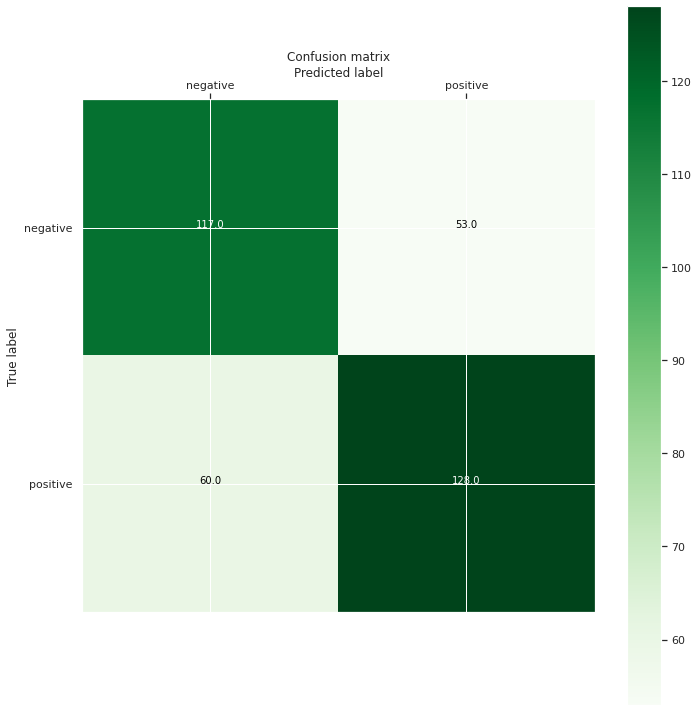

In [132]:
plot_confusion_matrix(create_confusion_matrix( predictions , testData['polarity'].values , 2), ['negative' , 'positive'], normalize=False, title='Confusion matrix', cmap=plt.cm.Greens)
